In [77]:
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import seaborn as sns


caracteristiques = pd.read_csv('data/caracteristiques-20191.csv',
                                index_col='Num_Acc', 
                                usecols=['Num_Acc','dep', 'lum', 'agg', 'atm','col'], dtype={'dep' : object})
usagers = pd.read_csv('data/usagers-2019.csv',
                        sep=';', index_col='Num_Acc',
                        usecols=['Num_Acc', 'sexe', 'an_nais', 'grav', 'secu1', 'secu2', 'secu3'])

lieux = pd.read_csv('data/lieux-2019.csv',
                    sep=';', index_col='Num_Acc',
                    usecols=['Num_Acc', 'catr','circ', 'nbv', 'plan', 'surf'])

vehicules = pd.read_csv('data/vehicules-2019.csv',
                        sep=';', index_col='Num_Acc',
                        usecols=['Num_Acc', 'catv' ])

donnes_brut = pd.read_csv('data/donnes.csv', index_col='dep')

display(caracteristiques)

,lum,dep,agg,atm,col
Num_Acc,,,,,
201900000001,4,93,1,1,2
201900000002,3,93,1,1,6
201900000003,1,92,1,1,4
201900000004,5,94,1,1,4
201900000005,3,94,1,1,2
...,...,...,...,...,...
201900058836,1,69,1,5,2
201900058837,1,67,1,8,4
201900058838,4,94,1,1,6


In [78]:



# Variable agg (0 : Accident hors agglo, 1 : Accident en Agglo )
caracteristiques['agglo'] = caracteristiques['agg']-1
# Variable nuit (0 : Accident de jour, 1 : Accident de nuit)
caracteristiques['nuit'] = np.where(caracteristiques['lum'] == 1, 0, 1)
# Variable atm_extreme :
#   0 : atmosphère normale lors de l'accident = [normale, pluie légère, temps éblouissant, temps couvert]
#   1 : atmosphère extreme lors de l'accident = [pluie forte, neige/grele, brouillard/fumée, vent fort/tempete]
caracteristiques['atm_extreme'] = np.where((caracteristiques['atm'] < 2) | (caracteristiques['atm'] > 6),0, 1)
# Varriable col_front (0 : collision non frontale, 1: collision frontale)
caracteristiques['col_front'] = np.where(caracteristiques['col'] == 1,1,0)


# Variable auto : (0 : Accident hors autoroute, 1: Accident sur autouroute)
lieux['auto'] = np.where(lieux['catr'] == 1, 1, 0)
# Variable natio (0 : Accident hors nationale, 1: Accident sur nationale)
lieux['natio'] = np.where(lieux['catr'] == 2, 1, 0)
# Variable depart : (0 : Accident hors departementale, 1: Accident sur départementale)
lieux['depart'] = np.where(lieux['catr'] == 3, 1, 0)
# Variable bidirec (0 : Accident sur route non bidirectionnelle, 1 : Accident sur route bidirectionnelle)
lieux['bidirec'] = np.where(lieux['circ'] == 2, 1, 0)
# Variable virage (0 : Accident ayant eu lieu sur un plan rectiligne, 1 : Accident ayant eu lieu sur un plan non rectiligne)
lieux['virage'] = np.where(lieux['plan'] > 1, 1, 0)
# Variable surface_normale (0 : Etat de la surface normale, 1 : Etat de la surface non normale)
lieux ['surface_normale'] = np.where(lieux['surf'] == 1, 1, 0)




# Calcul age
usagers['age'] = 2019 - usagers['an_nais'] 
# 
usagers['femme'] = np.where(usagers['sexe'] == 2, 1, 0)
usagers['homme'] = np.where(usagers['sexe'] == 1, 1, 0)
# 0 : pas mort, 1 : mort
usagers['mort'] = np.where(usagers['grav'] == 2, 1, 0)


df = pd.DataFrame()
# Moyenne d'age par accidents
df['age_moy'] = usagers.age.groupby('Num_Acc').mean()
# Nombre de femmes et homme par accidents
df['femme'] = usagers.femme.groupby('Num_Acc').sum()
df['homme'] = usagers.homme.groupby('Num_Acc').sum()
df['usagers'] = usagers.groupby('Num_Acc').size()
# Nombre de morts par accidents
df['nb_mort'] = usagers.mort.groupby('Num_Acc').sum()


caracteristiques = caracteristiques.join([df, lieux])

data = pd.DataFrame()
# Nombre de morts par départements
data['morts'] = caracteristiques.groupby('dep')['nb_mort'].sum()
# Nombre d'accidents par départements
data['accidents'] = caracteristiques.groupby('dep').size()
# Nombre d'accidents qui ont eu lieu en agglomération
data['agglo'] = caracteristiques.groupby('dep')['agglo'].sum()
# Nombre d'accidents qui ont eu lieu pendant la nuit
data['nuit'] = caracteristiques.groupby('dep')['nuit'].sum()
# Nombre d'accidents ayant eu lieu sous conditions atmosphériques extremes
data['atm_extreme'] = caracteristiques.groupby('dep')['atm_extreme'].sum()
# Nombre d'accidents en collision frontale
data['col_front'] = caracteristiques.groupby('dep')['col_front'].sum()
# Nombre d'accidents impliquant des femmes
data['femme'] = caracteristiques.groupby('dep')['femme'].sum()
# Nombre d'accidents impliquant des hommes
data['homme'] = caracteristiques.groupby('dep')['homme'].sum()
# Nombre d'accidentés
data['usagers'] = caracteristiques.groupby('dep')['usagers'].sum()
# Nombre moyen d'accidentés par accidents
data['usagers_moy'] = caracteristiques.groupby('dep')['usagers'].mean()
# Age moyen des accidentés
data['age_moy'] = caracteristiques.groupby('dep')['age_moy'].mean()
# Nombre d'accidents sur l'autoroute
data['auto'] = caracteristiques.groupby('dep')['auto'].sum()
# Nombre d'accidents sur nationale
data['natio'] = caracteristiques.groupby('dep')['natio'].sum()
# Nombre d'accidents sur départementale
data['depart'] = caracteristiques.groupby('dep')['depart'].sum()
# Nombre d'accidents sur une voie bidirectionelle
data['bidirec'] = caracteristiques.groupby('dep')['bidirec'].sum()
# Nombre d'accidents ayant eu lieu dans des virages
data['virage'] = caracteristiques.groupby('dep')['virage'].sum()
# Nombre de voies moyen par accidents
data['nbv_moy'] = caracteristiques.groupby('dep')['nbv'].mean()
# Nombre d'accidents ayant eu lieu sur une route avec surface normale
data['surface_normale'] = caracteristiques.groupby('dep')['surface_normale'].sum()

data = data.drop(data.index[96:])
donnes_brut = donnes_brut.drop(donnes_brut.index[96:])
allah = data.merge(donnes_brut)
display(data)
display(donnes_brut)
display(allah)

,morts,accidents,agglo,nuit,atm_extreme,col_front,femme,homme,usagers,usagers_moy,age_moy,auto,natio,depart,bidirec,virage,nbv_moy,surface_normale
dep,,,,,,,,,,,,,,,,,,
01,34,474,179,175,93,64,394,750,1144,2.413502,39.942207,57,0,337,359,139,2.111814,353
02,31,210,93,75,35,41,146,318,464,2.209524,39.791973,11,20,127,168,39,2.019048,162
03,23,248,108,73,38,42,194,356,550,2.217742,41.848771,9,19,163,215,83,2.044355,187
04,17,230,54,51,11,49,191,335,526,2.286957,45.430645,5,23,172,205,107,1.973913,203
05,18,252,139,51,16,33,231,383,614,2.436508,42.962380,1,84,113,231,78,2.043651,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,30,1460,748,500,273,83,1055,2329,3384,2.317808,37.982585,305,389,233,556,225,2.876712,1070
92,25,2446,2018,817,371,102,1487,3817,5304,2.168438,39.033907,350,94,1242,1081,256,2.608749,1923
93,30,3130,2327,1047,574,177,1942,5167,7109,2.271246,36.287971,745,0,1358,1321,384,3.204473,2404


,morts,accidents,population,pop_femme,pop_homme,pop_20_39,pop_40_59,pop_60_plus,superficie,densite_pop,...,km_dep,bdg_voirie,infractions_retrait_points,effectif_tourisme,taux_actif_tourisme,Tx_eq_voiture_menage,% foyer 1 voiture,% menage 2 voiture ou +,nb_radar,educ1
dep,,,,,,,,,,,,,,,,,,,,,
01,34,474,652432,330575,321857,148849,178829,155125,5762.39,113.222465,...,13250.0,75.57,81380,8257.723055,0.026318,91.0,43.7,47.2,28,8.9
02,22,384,531345,272216,259129,115580,137655,144522,7361.65,72.177433,...,11131.0,26.25,63429,4335.983234,0.018373,83.1,46.2,36.9,28,4.1
03,36,318,335975,174782,161193,62465,87252,116771,7340.11,45.772475,...,13179.0,20.54,46903,5003.066558,0.034978,85.0,47.1,37.9,31,4.9
04,18,194,164308,84465,79843,30297,43729,55451,6925.22,23.726033,...,7094.0,40.71,24132,5230.901546,0.073999,87.9,49.8,38.1,16,7.5
05,103,2997,141220,72262,68958,27481,38222,44922,5548.68,25.451098,...,4762.0,40.28,16973,6316.783219,0.098504,88.4,50.4,38.0,16,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,30,1460,1301659,664210,637449,332142,346586,266605,1804.40,721.380514,...,6056.0,44.07,205106,6826.361364,0.010791,83.5,48.7,34.8,50,13.5
92,25,2446,1624357,851149,773208,456431,433477,326704,175.61,9249.797848,...,1798.0,79.73,204699,15466.727660,0.018588,64.5,49.7,14.8,49,30.7
93,30,3130,1644903,835909,808994,466414,418395,277838,236.20,6964.026249,...,2412.0,53.09,197543,12015.426830,0.015418,61.4,46.3,15.0,20,10.1


,morts,accidents,agglo,nuit,atm_extreme,col_front,femme,homme,usagers,usagers_moy,...,km_dep,bdg_voirie,infractions_retrait_points,effectif_tourisme,taux_actif_tourisme,Tx_eq_voiture_menage,% foyer 1 voiture,% menage 2 voiture ou +,nb_radar,educ1
0,34,474,179,175,93,64,394,750,1144,2.413502,...,13250.0,75.57,81380,8257.723055,0.026318,91.0,43.7,47.2,28,8.9
1,31,210,93,75,35,41,146,318,464,2.209524,...,17205.0,54.31,33838,4532.880889,0.037407,88.7,47.4,41.3,14,5.5
2,23,248,108,73,38,42,194,356,550,2.217742,...,11182.0,23.45,15014,6069.575886,0.123115,86.9,46.8,40.1,14,7.7
3,17,230,54,51,11,49,191,335,526,2.286957,...,11305.0,90.42,166069,26097.676690,0.051862,82.5,50.4,32.1,67,11.9
4,18,252,139,51,16,33,231,383,614,2.436508,...,11371.0,68.92,102494,7156.389716,0.022831,85.8,46.0,39.8,53,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,30,1460,748,500,273,83,1055,2329,3384,2.317808,...,6056.0,44.07,205106,6826.361364,0.010791,83.5,48.7,34.8,50,13.5
92,25,2446,2018,817,371,102,1487,3817,5304,2.168438,...,1798.0,79.73,204699,15466.727660,0.018588,64.5,49.7,14.8,49,30.7
93,30,3130,2327,1047,574,177,1942,5167,7109,2.271246,...,2412.0,53.09,197543,12015.426830,0.015418,61.4,46.3,15.0,20,10.1
94,27,2681,2066,899,408,140,1795,4250,6045,2.254756,...,2393.0,77.59,161663,7639.166730,0.011029,67.8,50.1,17.8,27,17.9


<AxesSubplot: >

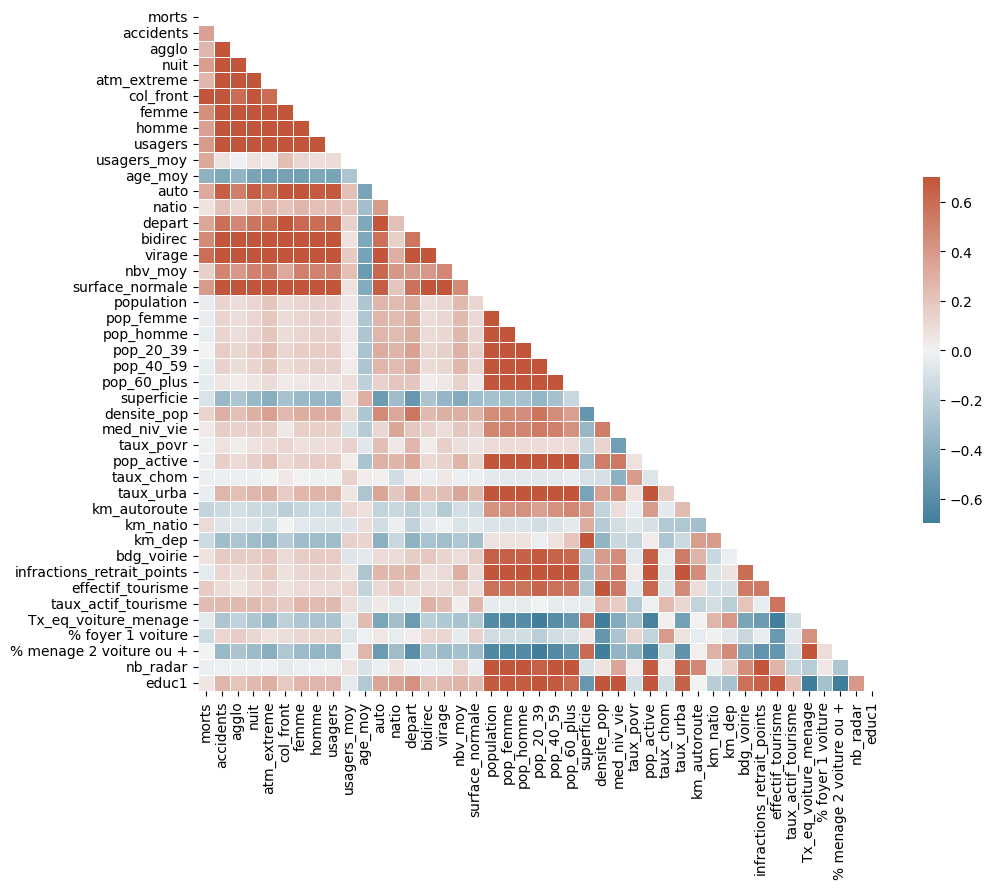

In [79]:
# Matrice de corrélation
corr = allah.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr , mask=mask, cmap=cmap, vmax=0.7, vmin=-0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [80]:
reg1 = smf.ols(formula ='morts ~ virage + km_dep', data=allah).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  morts   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     25.18
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.82e-09
Time:                        15:42:49   Log-Likelihood:                -399.88
No. Observations:                  96   AIC:                             805.8
Df Residuals:                      93   BIC:                             813.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8471      5.540      2.860      0.0

In [81]:
reg = smf.ols(formula='morts ~ femme + nuit', data=data).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  morts   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     22.89
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           8.23e-09
Time:                        15:42:49   Log-Likelihood:                -401.43
No. Observations:                  96   AIC:                             808.9
Df Residuals:                      93   BIC:                             816.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.1927      2.484      8.532      0.0

In [82]:
import itertools

lachancla =[]
for i in data.iloc[:, 2:].columns:
    lachancla.append(i)

yatangaki=[]
for i in range(1,len(lachancla)+1):
   yatangaki.append(list(itertools.combinations(lachancla,i)))

issou=[]
for i in range(len(yatangaki)):
    for j in range(len(yatangaki[i])):
        issou.append('+'.join(yatangaki[i][j]))

print(f'{len(issou)} \n {issou[65534]}')

65535 
 agglo+nuit+atm_extreme+col_front+femme+homme+usagers+usagers_moy+age_moy+auto+natio+depart+bidirec+virage+nbv_moy+surface_normale
